<a href="https://colab.research.google.com/github/sawamura8/flask-mnist-app/blob/main/%E3%81%AD%E3%81%93%E3%81%AF%E3%82%93%E3%81%B9%E3%81%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# ネコの画像だけを集めるコード catcollect.ipynb

# ネコの品種だけリストアップしておく
catbreeds=[
    'Abyssinian',
    'Bengal',
    'Birman',
    'Bombay',
    'British_Shorthair',
    'Egyptian_Mau',
    'Maine_Coon',
    'Persian',
    'Ragdoll',
    'Russian_Blue',
    'Siamese',
    'Sphynx',
]

# ネコの画像のパスだけをリストに格納
import glob
imglist = []
for catbreed in catbreeds:
    imgs = glob.glob(f'/content/drive/MyDrive/images/{catbreed}*.jpg')
    imglist += imgs

# imagesフォルダからネコの画像だけ複製してcatbreedsフォルダに移動
import shutil
new_dir_path = 'catbreeds'

for src in imglist:
    shutil.copy(src, new_dir_path)

In [39]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
#必要なライブラリ用意
import numpy as np
import random
import glob
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from tqdm import tqdm
from torchvision import models, transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
import time

In [26]:
#シードを固定

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [27]:
#データの前処理を行うクラスを定義

class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((resize, resize)),
                #transforms.RandomHorizontalFlip(p=0.5),
                #transforms.RandomCrop(size =(150, 150), padding=18),
                transforms.ToTensor(),
                #transforms.Normalize(mean,std)
            ]),
            'val': transforms.Compose([
                transforms.Resize((resize,resize)),
                transforms.ToTensor(),
                #transforms.transforms.Normalize(mean, std)
            ]),
            'test' : transforms.Compose([
                transforms.Resize((resize,resize)),
                transforms.ToTensor(),
                #transforms.transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [28]:
#データにネコの品種のラベル付けを行うクラスを定義

class CatBreedsDataset(data.Dataset):
    def __init__(self, file_list, phase, breeds,transform = None):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        self.breeds = breeds

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img = img.convert("RGB") #RGBチャンネルに限定しておく

        img_trans = self.transform(
            img, self.phase)

        label = img_path.split('/')[-1].split('_')[0]
        if label in breeds.keys():
          label = breeds[label]
        else:
          label = 0


        return img_trans, label

In [29]:
breeds ={
    'Abyssinian':0,
    'Bengal':1,
    'Birman':2,
    'Bombay':3,
    'British':4,
    'Egyptian':5,
    'Maine':6,
    'Persian':7,
    'Ragdoll':8,
    'Russian':9,
    'Siamese':10,
    'Sphynx':11,
}
    
breed_paths={}

for key,value in breeds.items():
  breed_paths[key]= glob.glob(f'/content/drive/MyDrive/images/{key}*.jpg')

In [30]:
#学習データの数を決める

Ntrain = 180
train_list = []

for key,value in breed_paths.items():
  train_list += value[:Ntrain]

In [31]:
#学習データを訓練データと検証データに分けるためのパスのリストを定義

train_idx, valid_idx = train_test_split(range(len(train_list)), test_size = 0.25, random_state = 0)

train_path_list = []
val_path_list = []
for index in train_idx:
    i = train_list[index]
    train_path_list.append(i)

for index in valid_idx:
    i = train_list[index]
    val_path_list.append(i)

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
#テストデータの数を決める

test_path_list = []

for key,value in breed_paths.items():
  test_path_list += value[Ntrain:]

In [34]:
#訓練、検証、テストデータの数を確認

len(train_path_list), len(val_path_list), len(test_path_list)
 #-> (1620, 540, 240)

(1620, 540, 240)

In [35]:
#パスのリストからデータセットを読み込む

size = 150
mean = (0.5,0.5,0.5)
std = (0.5,0.5,0.5)

train_dataset = CatBreedsDataset(
    file_list = train_path_list, transform = ImageTransform(size, mean, std), phase = 'train',breeds=breeds)

val_dataset = CatBreedsDataset(
    file_list = val_path_list, transform = ImageTransform(size, mean, std), phase = 'val',breeds=breeds)

test_dataset = CatBreedsDataset(
    file_list = test_path_list, transform = ImageTransform(size, mean, std), phase = 'test',breeds=breeds)

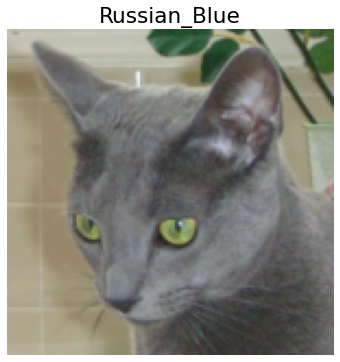

In [36]:
# 画像が正しく読み込めているか確認

breedsdict ={
    0:'Abyssinian',
    1:'Bengal',
    2:'Birman',
    3:'Bombay',
    4:'British_Shorthair',
    5:'Egyptian_Mau',
    6:'Maine_Coon',
    7:'Persian',
    8:'Ragdoll',
    9:'Russian_Blue',
    10:'Siamese',
    11:'Sphynx'
}

num =21 # 画像がランダムに並んでいるので番号を手動で選択

plt.rcParams["font.size"] = 18
plt.figure(figsize=(6, 6))
x, t = train_dataset[num]
exbreed = breedsdict[t]
plt.title(exbreed)
plt.axis('off')
plt.imshow(x.permute(1, 2, 0))
plt.savefig(f'/content/catbreeds{exbreed}.jpg')

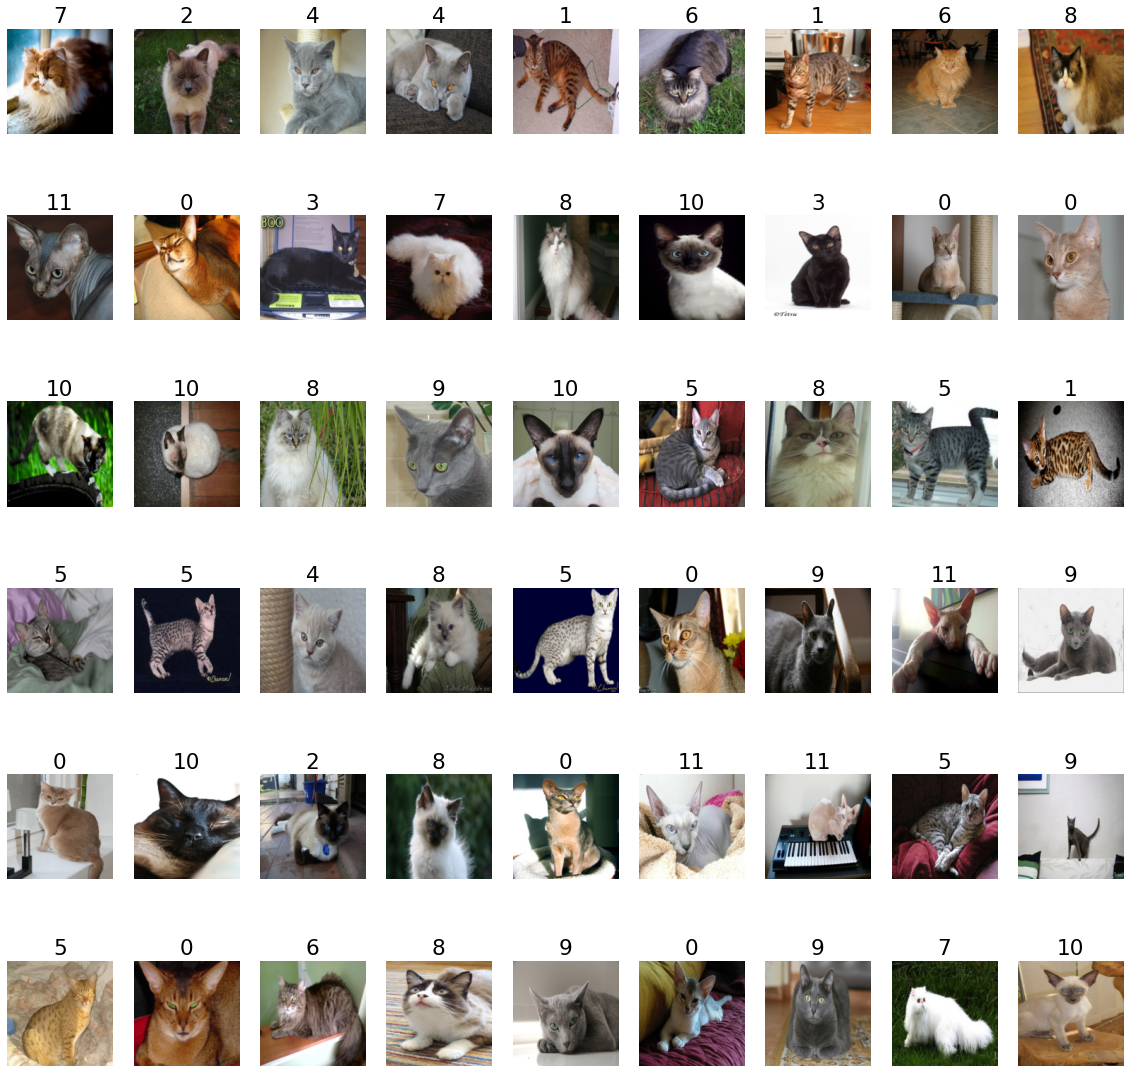

In [37]:
# データをまとめて確認する
plt.figure(figsize=(20, 20))
for n in range(54):
    x, t = train_dataset[n]
    plt.subplot(6, 9, n+1)
    plt.title(train_dataset[n][1])
    plt.axis('off')
    plt.imshow(x.permute(1, 2, 0))
plt.savefig('/content/catbreeds.jpg')

In [41]:
#データローダーでデータをミニバッチに分ける

batch_size = 20
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle = True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle = False)

test_dataloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle = False)

dataloaders_dict = {'train': train_dataloader,
                    'val': val_dataloader}

In [42]:
#Efficientnetモデルのインスタンス化

from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b7')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 12) # 12クラスを分類
EPOCHS = 50
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

Loaded pretrained weights for efficientnet-b7


In [43]:
#訓練と検証を行う関数を定義

def train_model(model, dataloaders_dict, loss_fn, optimizer, epochs, scheduler):
    history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    for epoch in range(epochs):
        print(f'{epoch + 1} start')
        print('----------')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0.0

            #if (epoch == 0) and (phase == 'train'):
            #    continue

            for inputs, labels in tqdm(dataloaders_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    pred_value, pred_label = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(pred_label == labels.data)



            epoch_loss /= len(dataloaders_dict[phase].dataset)*1.0
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)*1.0

            print(f'{phase} Loss: {epoch_loss :.4f} Acc : {epoch_acc :.4f}')
            if phase == 'train':
                history['loss'].append(epoch_loss)
                history['acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

            if phase == 'train':
                scheduler.step()
    return history

In [45]:
#学習開始、学習曲線のためにhistoryに格納
%%time
history = train_model(model, dataloaders_dict, loss_fn, optimizer, EPOCHS, scheduler)

1 start
----------


100%|██████████| 81/81 [00:56<00:00,  1.44it/s]


train Loss: 0.0711 Acc : 0.9864


100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


val Loss: 0.5691 Acc : 0.7981
2 start
----------


100%|██████████| 81/81 [00:51<00:00,  1.57it/s]


train Loss: 0.0664 Acc : 0.9907


100%|██████████| 27/27 [00:08<00:00,  3.22it/s]


val Loss: 0.5676 Acc : 0.7981
3 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0560 Acc : 0.9926


100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


val Loss: 0.5673 Acc : 0.8074
4 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0625 Acc : 0.9895


100%|██████████| 27/27 [00:09<00:00,  2.86it/s]


val Loss: 0.5696 Acc : 0.8056
5 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.64it/s]


train Loss: 0.0650 Acc : 0.9883


100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


val Loss: 0.5693 Acc : 0.8037
6 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.64it/s]


train Loss: 0.0519 Acc : 0.9926


100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


val Loss: 0.5676 Acc : 0.8019
7 start
----------


100%|██████████| 81/81 [00:50<00:00,  1.61it/s]


train Loss: 0.0692 Acc : 0.9907


100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


val Loss: 0.5661 Acc : 0.8056
8 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0502 Acc : 0.9963


100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


val Loss: 0.5661 Acc : 0.8056
9 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0668 Acc : 0.9877


100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


val Loss: 0.5663 Acc : 0.8000
10 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0667 Acc : 0.9914


100%|██████████| 27/27 [00:07<00:00,  3.53it/s]


val Loss: 0.5644 Acc : 0.8019
11 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0570 Acc : 0.9920


100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


val Loss: 0.5671 Acc : 0.7981
12 start
----------


100%|██████████| 81/81 [00:50<00:00,  1.61it/s]


train Loss: 0.0663 Acc : 0.9840


100%|██████████| 27/27 [00:07<00:00,  3.67it/s]


val Loss: 0.5657 Acc : 0.8000
13 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0653 Acc : 0.9864


100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


val Loss: 0.5655 Acc : 0.8019
14 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0594 Acc : 0.9951


100%|██████████| 27/27 [00:07<00:00,  3.63it/s]


val Loss: 0.5655 Acc : 0.8019
15 start
----------


100%|██████████| 81/81 [00:50<00:00,  1.61it/s]


train Loss: 0.0497 Acc : 0.9957


100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


val Loss: 0.5660 Acc : 0.7963
16 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0612 Acc : 0.9926


100%|██████████| 27/27 [00:07<00:00,  3.64it/s]


val Loss: 0.5658 Acc : 0.8019
17 start
----------


100%|██████████| 81/81 [00:50<00:00,  1.61it/s]


train Loss: 0.0648 Acc : 0.9895


100%|██████████| 27/27 [00:07<00:00,  3.52it/s]


val Loss: 0.5652 Acc : 0.7981
18 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.64it/s]


train Loss: 0.0571 Acc : 0.9920


100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


val Loss: 0.5640 Acc : 0.8019
19 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0514 Acc : 0.9932


100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


val Loss: 0.5666 Acc : 0.8019
20 start
----------


100%|██████████| 81/81 [00:50<00:00,  1.61it/s]


train Loss: 0.0662 Acc : 0.9901


100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


val Loss: 0.5655 Acc : 0.7981
21 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0564 Acc : 0.9914


100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


val Loss: 0.5670 Acc : 0.8000
22 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0496 Acc : 0.9932


100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


val Loss: 0.5675 Acc : 0.8019
23 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0558 Acc : 0.9914


100%|██████████| 27/27 [00:07<00:00,  3.64it/s]


val Loss: 0.5665 Acc : 0.8037
24 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0536 Acc : 0.9926


100%|██████████| 27/27 [00:07<00:00,  3.63it/s]


val Loss: 0.5666 Acc : 0.8056
25 start
----------


100%|██████████| 81/81 [00:50<00:00,  1.62it/s]


train Loss: 0.0516 Acc : 0.9932


100%|██████████| 27/27 [00:07<00:00,  3.63it/s]


val Loss: 0.5671 Acc : 0.7981
26 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0547 Acc : 0.9914


100%|██████████| 27/27 [00:07<00:00,  3.68it/s]


val Loss: 0.5668 Acc : 0.8019
27 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0515 Acc : 0.9957


100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


val Loss: 0.5662 Acc : 0.8037
28 start
----------


100%|██████████| 81/81 [00:50<00:00,  1.61it/s]


train Loss: 0.0524 Acc : 0.9907


100%|██████████| 27/27 [00:07<00:00,  3.63it/s]


val Loss: 0.5661 Acc : 0.8019
29 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.62it/s]


train Loss: 0.0537 Acc : 0.9907


100%|██████████| 27/27 [00:07<00:00,  3.69it/s]


val Loss: 0.5670 Acc : 0.7981
30 start
----------


100%|██████████| 81/81 [00:50<00:00,  1.61it/s]


train Loss: 0.0571 Acc : 0.9901


100%|██████████| 27/27 [00:07<00:00,  3.64it/s]


val Loss: 0.5671 Acc : 0.7981
31 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0492 Acc : 0.9963


100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


val Loss: 0.5658 Acc : 0.7981
32 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0495 Acc : 0.9944


100%|██████████| 27/27 [00:07<00:00,  3.62it/s]


val Loss: 0.5640 Acc : 0.8000
33 start
----------


100%|██████████| 81/81 [00:50<00:00,  1.62it/s]


train Loss: 0.0515 Acc : 0.9944


100%|██████████| 27/27 [00:07<00:00,  3.70it/s]


val Loss: 0.5633 Acc : 0.8019
34 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.62it/s]


train Loss: 0.0461 Acc : 0.9938


100%|██████████| 27/27 [00:07<00:00,  3.65it/s]


val Loss: 0.5620 Acc : 0.8019
35 start
----------


100%|██████████| 81/81 [00:50<00:00,  1.61it/s]


train Loss: 0.0554 Acc : 0.9932


100%|██████████| 27/27 [00:07<00:00,  3.65it/s]


val Loss: 0.5614 Acc : 0.8037
36 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0529 Acc : 0.9907


100%|██████████| 27/27 [00:07<00:00,  3.64it/s]


val Loss: 0.5638 Acc : 0.8037
37 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.62it/s]


train Loss: 0.0467 Acc : 0.9951


100%|██████████| 27/27 [00:07<00:00,  3.63it/s]


val Loss: 0.5641 Acc : 0.8019
38 start
----------


100%|██████████| 81/81 [00:50<00:00,  1.60it/s]


train Loss: 0.0522 Acc : 0.9914


100%|██████████| 27/27 [00:07<00:00,  3.65it/s]


val Loss: 0.5632 Acc : 0.8000
39 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.62it/s]


train Loss: 0.0428 Acc : 0.9951


100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


val Loss: 0.5644 Acc : 0.8037
40 start
----------


100%|██████████| 81/81 [00:50<00:00,  1.61it/s]


train Loss: 0.0444 Acc : 0.9951


100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


val Loss: 0.5636 Acc : 0.8037
41 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0409 Acc : 0.9944


100%|██████████| 27/27 [00:07<00:00,  3.66it/s]


val Loss: 0.5628 Acc : 0.8019
42 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0488 Acc : 0.9914


100%|██████████| 27/27 [00:07<00:00,  3.63it/s]


val Loss: 0.5616 Acc : 0.8019
43 start
----------


100%|██████████| 81/81 [00:50<00:00,  1.62it/s]


train Loss: 0.0450 Acc : 0.9932


100%|██████████| 27/27 [00:07<00:00,  3.67it/s]


val Loss: 0.5603 Acc : 0.8037
44 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0404 Acc : 0.9938


100%|██████████| 27/27 [00:07<00:00,  3.66it/s]


val Loss: 0.5625 Acc : 0.8019
45 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0376 Acc : 0.9951


100%|██████████| 27/27 [00:08<00:00,  3.35it/s]


val Loss: 0.5631 Acc : 0.8056
46 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.62it/s]


train Loss: 0.0419 Acc : 0.9932


100%|██████████| 27/27 [00:07<00:00,  3.63it/s]


val Loss: 0.5621 Acc : 0.8074
47 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0418 Acc : 0.9907


100%|██████████| 27/27 [00:07<00:00,  3.63it/s]


val Loss: 0.5654 Acc : 0.8074
48 start
----------


100%|██████████| 81/81 [00:50<00:00,  1.61it/s]


train Loss: 0.0322 Acc : 0.9981


100%|██████████| 27/27 [00:07<00:00,  3.63it/s]


val Loss: 0.5678 Acc : 0.8000
49 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.63it/s]


train Loss: 0.0322 Acc : 0.9951


100%|██████████| 27/27 [00:07<00:00,  3.65it/s]


val Loss: 0.5659 Acc : 0.7963
50 start
----------


100%|██████████| 81/81 [00:49<00:00,  1.62it/s]


train Loss: 0.0272 Acc : 0.9975


100%|██████████| 27/27 [00:07<00:00,  3.59it/s]

val Loss: 0.5692 Acc : 0.7963
CPU times: user 36min 36s, sys: 8min 55s, total: 45min 31s
Wall time: 48min 7s


In [46]:
# 学習済みモデルの保存
modeldir = '/content/drive/MyDrive/'
savedparams = 'catbreedscls_1620data_efficientnet_50epochs_lr0001'
torch.save(model.state_dict(), modeldir+savedparams+'.mt')

In [47]:
# 学習曲線を描くための関数を定義

def plot_graph(values1, values2, rng, label1, label2, figname):
    plt.plot(range(rng), values1, label=label1)
    plt.plot(range(rng), values2, label=label2)
    plt.title(os.path.splitext(os.path.basename(figname))[0])
    plt.legend()
    plt.grid()
    plt.savefig(figname)
    plt.show()

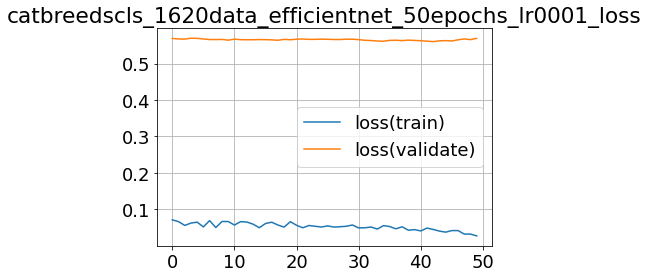

In [48]:
#loss curveを描画

t_losses = history['loss']
t_accus = history['acc']
v_losses = history['val_loss']
v_accus = history['val_acc']

lossfigname = '_loss' + '.jpg'

plot_graph(t_losses, v_losses, EPOCHS, 'loss(train)', 'loss(validate)',modeldir+savedparams+lossfigname)

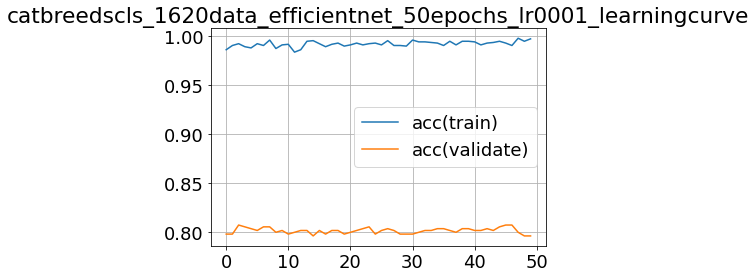

In [49]:
#learning curveを描画

lcfigname = '_learningcurve' + '.jpg'

t_accus_np = [i.to('cpu').detach().numpy().copy() for i in t_accus]
v_accus_np = [i.to('cpu').detach().numpy().copy() for i in v_accus]

plot_graph(t_accus_np, v_accus_np, EPOCHS, 'acc(train)', 'acc(validate)',modeldir + savedparams + lcfigname)

In [50]:
# ネットワークの準備

model = EfficientNet.from_pretrained('efficientnet-b7').cpu().eval()
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 12)

Loaded pretrained weights for efficientnet-b7


In [51]:
# 重みの読み込み
modeldir = '/content/drive/MyDrive/'
savedparams = 'catbreedscls_1620data_efficientnet_50epochs_lr0001'
model.load_state_dict(torch.load(modeldir+savedparams+ '.mt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [52]:
#modelを評価状態にする
model.eval()

#テストデータセットを読み込み
# x : 画像、 t : ラベル
x, t = test_dataset[1]

# NNによる出力値の算出
y = model(x.unsqueeze(0))
print(y)
# --> tensor([[ 5.9189,  1.7976, -1.0649, -1.4619, -0.3423,  1.3339, -1.4173, -2.0221,
#         -1.4546, -0.8399,  0.6408, -0.9661]], grad_fn=<AddmmBackward0>)

# ソフトマックス関数で確率に変換
y = F.softmax(y)
y
# --> tensor([[9.6264e-01, 1.5617e-02, 8.9217e-04, 5.9985e-04, 1.8376e-03, 9.8222e-03,
#         6.2716e-04, 3.4255e-04, 6.0421e-04, 1.1173e-03, 4.9114e-03, 9.8480e-04]],
#       grad_fn=<SoftmaxBackward0>)　0番目のラベル(=アビシニアン)の確率が最も高い

tensor([[ 8.5413,  0.7168, -2.6906,  0.5770, -1.2631, -1.4272, -1.3887, -2.2708,
         -2.2858, -0.1007, -0.0165,  1.0303]], grad_fn=<AddmmBackward0>)


<ipython-input-52-74eda2366cd4>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(y)


tensor([[9.9814e-01, 3.9909e-04, 1.3221e-05, 3.4701e-04, 5.5106e-05, 4.6767e-05,
         4.8605e-05, 2.0118e-05, 1.9818e-05, 1.7620e-04, 1.9169e-04, 5.4601e-04]],
       grad_fn=<SoftmaxBackward0>)

In [53]:
# テストデータに対する結果を表示

prob = []
prdbreed = []
pred = []
Y = []
for i, (x,y) in enumerate(test_dataloader):
    with torch.no_grad():
        output = model(x)
    #prob += [i.to('cpu').detach().numpy().copy()[0] for i in output]
    #prob += [round(F.softmax(l)[0].to('cpu').detach().numpy().copy()*100,1) for l in output]
    prdbreed += [torch.argmax(F.softmax(l)).to('cpu').detach().numpy().copy() for l in output]
    prob += [round(torch.max(F.softmax(l)).to('cpu').detach().numpy().copy()*100,1) for l in output]

    pred += [int(l.argmax()) for l in output]
    Y += [int(l) for l in y]

print(classification_report(Y, pred))

<ipython-input-53-93e2a56331b5>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prdbreed += [torch.argmax(F.softmax(l)).to('cpu').detach().numpy().copy() for l in output]
<ipython-input-53-93e2a56331b5>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob += [round(torch.max(F.softmax(l)).to('cpu').detach().numpy().copy()*100,1) for l in output]


              precision    recall  f1-score   support

           0       0.61      0.85      0.71        20
           1       0.85      0.85      0.85        20
           2       0.71      0.85      0.77        20
           3       1.00      0.95      0.97        20
           4       0.92      0.60      0.73        20
           5       0.90      0.90      0.90        20
           6       0.87      0.65      0.74        20
           7       0.83      1.00      0.91        20
           8       0.77      0.50      0.61        20
           9       0.74      0.85      0.79        20
          10       0.90      0.95      0.93        20
          11       0.90      0.90      0.90        20

    accuracy                           0.82       240
   macro avg       0.83      0.82      0.82       240
weighted avg       0.83      0.82      0.82       240



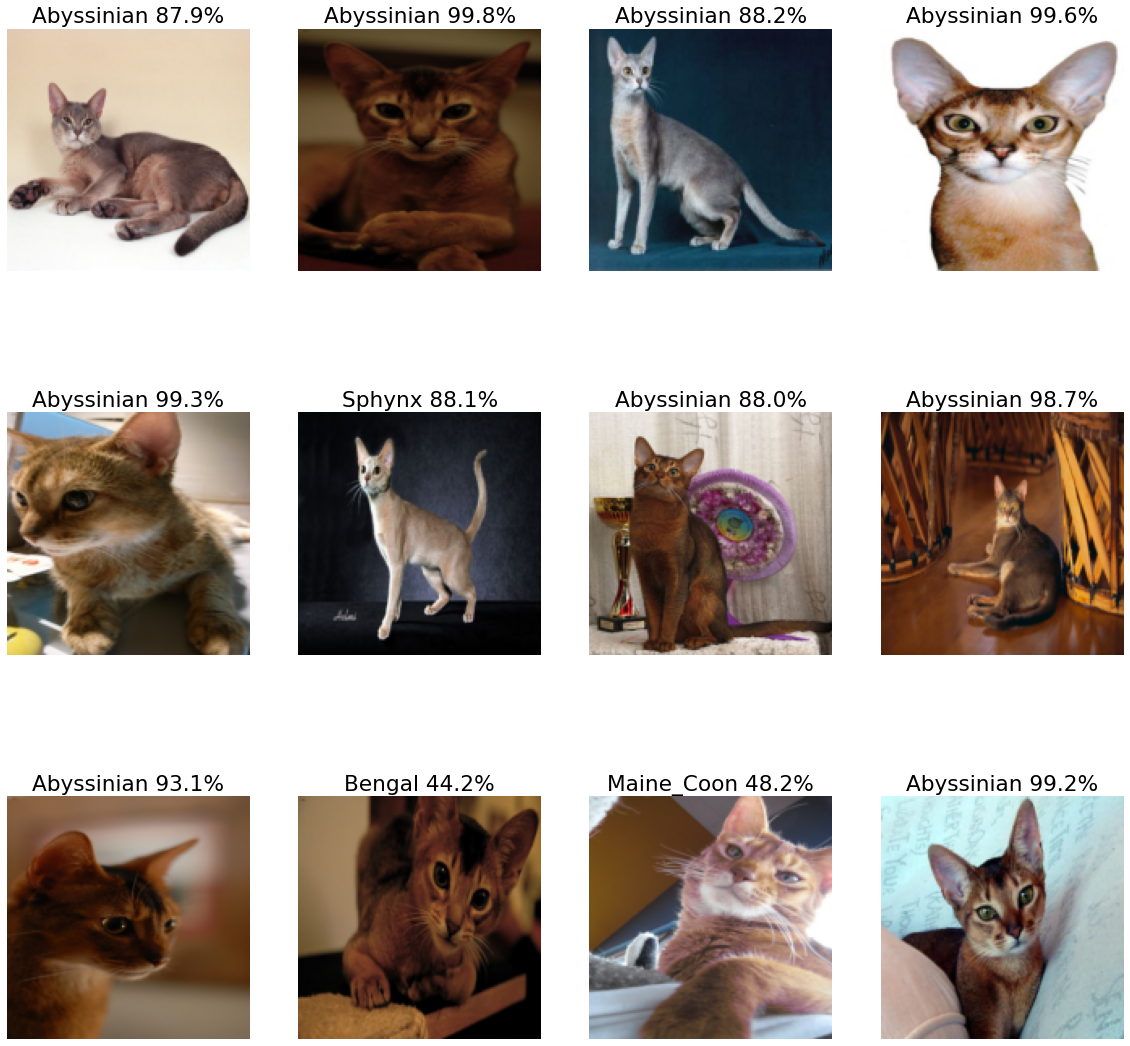

In [54]:
# テストデータに対する予測結果をまとめて表示

plt.rcParams["font.size"] = 18
plt.figure(figsize=(20, 20))
for n in range(12):
    x, t = test_dataset[n]
    plt.subplot(3, 4,n+1)
    plt.title(str(prob[n])+'%')
    plt.title('{} {}%'.format(breedsdict[int(prdbreed[n])],prob[n]))
    plt.axis('off')
    plt.imshow(x.permute(1, 2, 0))
plt.savefig('/content/drive/MyDrive/mystudy.jpg')

In [55]:
import torchvision.transforms.functional as F
import gradio as gr

@torch.no_grad()
def predict(img):
    img = Image.fromarray(img.astype("uint8"), "RGB")

    # 前処理
    img = F.resize(img, (150,150))
    img = F.to_tensor(img)
    img = img.unsqueeze(0)


    # 推論
    output = model(img).squeeze(0)
    probs = nn.functional.softmax(output, dim=0).numpy()

    # ラベルごとの確率をdictとして返す
    return {breedsdict[i]: float(probs[i]) for i in range(len(catbreeds))}

demo = gr.Interface(fn=predict, inputs=gr.inputs.Image(), outputs=gr.outputs.Label(num_top_classes=len(catbreeds)))
    
if __name__ == "__main__":
    demo.launch(share=True, debug=True)

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://ca8a09f822775236b7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ca8a09f822775236b7.gradio.live
